### import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, confusion_matrix, f1_score, classification_report, recall_score, roc_curve

import optuna

import psycopg2
from config import *

from datetime import timedelta

import utm
import time

import glob

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import class_weight
import optuna

In [2]:
conexion = psycopg2.connect(database=db_database, 
                                user=db_user, 
                                password=db_password, 
                                host=db_host, 
                                port=db_port)

In [3]:
fechaHasta='2023-01-01'
pathModelos = '/data/proyectos/GRAPEVINE/Models/fjlacueva/Phenology/RandomForests'
query="select * from public.sabana_sin_rad where fecha <= '"+ fechaHasta + "';"
sabana = pd.read_sql_query(query, con=conexion).drop_duplicates()
sabana

,phenologystageid,variedad,codigo,longitude,latitude,altitud,doc_id,fecha,estacion,season,...,do_Borja,do_Calatayud,do_Cariñena,do_Somontano,variedad_CABERNET SAUVIGNON,variedad_CHARDONNAY,variedad_GARNACHA,variedad_MAZUELA,variedad_SYRACH,variedad_TEMPRANILLO
0,10.0,CABERNET SAUVIGNON,50144A02900008,-1.195923,41.401890,506.0,Cariñena,2019-10-04,gv01,2018_2019,...,0,0,1,0,1,0,0,0,0,0
1,10.0,GARNACHA,50144A02300023,-1.176083,41.371589,580.0,Cariñena,2019-10-04,gv01,2018_2019,...,0,0,1,0,0,0,1,0,0,0
2,10.0,SYRACH,50073A08400031,-1.207635,41.355942,565.0,Cariñena,2019-10-04,gv01,2018_2019,...,0,0,1,0,0,0,0,0,1,0
3,10.0,MAZUELA,50073A08600010,-1.179190,41.354589,592.0,Cariñena,2019-10-04,gv01,2018_2019,...,0,0,1,0,0,0,0,1,0,0
4,10.0,CABERNET SAUVIGNON,50144A02900008,-1.195923,41.401890,506.0,Cariñena,2019-10-05,gv01,2018_2019,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104630,10.0,MAZUELA,50073A08600010,-1.179190,41.354589,592.0,Cariñena,2019-10-02,gv01,2018_2019,...,0,0,1,0,0,0,0,1,0,0
104631,10.0,CABERNET SAUVIGNON,50144A02900008,-1.195923,41.401890,506.0,Cariñena,2019-10-03,gv01,2018_2019,...,0,0,1,0,1,0,0,0,0,0
104632,10.0,GARNACHA,50144A02300023,-1.176083,41.371589,580.0,Cariñena,2019-10-03,gv01,2018_2019,...,0,0,1,0,0,0,1,0,0,0
104633,10.0,SYRACH,50073A08400031,-1.207635,41.355942,565.0,Cariñena,2019-10-03,gv01,2018_2019,...,0,0,1,0,0,0,0,0,1,0


In [4]:
sabana['doc_id']=sabana.doc_id.fillna('New')

In [5]:
sabana.doc_id.value_counts()

Cariñena     68387
Borja        28918
Calatayud     7141
Somontano      189
Name: doc_id, dtype: int64

In [6]:
parcelas_train=[]
parcelas_test=[]
parcelas_vali=[]
for do in sabana.doc_id.unique():
    print(do)
    parcelas_do_train, parcelas_do_no=train_test_split(list(sabana[sabana.doc_id==do].codigo.unique()),
                                                       random_state=17,test_size=0.4)
    parcelas_train=parcelas_train+parcelas_do_train
    if len(parcelas_do_no)>1:
        parcelas_do_vali, parcelas_do_test=train_test_split(parcelas_do_no,test_size=0.5, random_state=17)
        parcelas_train=parcelas_train+parcelas_do_train
        parcelas_test=parcelas_test+parcelas_do_test
        parcelas_vali=parcelas_vali+parcelas_do_vali
    else:
        pascelas_test=parcelas_test+parcelas_do_no

Cariñena
Borja
Calatayud
Somontano


In [7]:
temp=sabana.copy()
datos_list=[]
for id_terr in temp.codigo.unique():
    datos_camp_terr=temp[temp['codigo']==id_terr]
    datos_camp_terr['next_fecha']=datos_camp_terr['fecha'].shift(-7)
    datos_camp_terr['next_pheno']=datos_camp_terr['phenologystageid'].shift(-7)
    datos_camp_terr=datos_camp_terr[(datos_camp_terr.next_fecha-datos_camp_terr.fecha).dt.days==7]
    datos_list.append(datos_camp_terr)
datos_total=pd.concat(datos_list).reset_index(drop=True)
datos_total

/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


,phenologystageid,variedad,codigo,longitude,latitude,altitud,doc_id,fecha,estacion,season,...,do_Cariñena,do_Somontano,variedad_CABERNET SAUVIGNON,variedad_CHARDONNAY,variedad_GARNACHA,variedad_MAZUELA,variedad_SYRACH,variedad_TEMPRANILLO,next_fecha,next_pheno
0,10.0,CABERNET SAUVIGNON,50144A02900008,-1.195923,41.401890,506.0,Cariñena,2019-10-04,gv01,2018_2019,...,1,0,1,0,0,0,0,0,2019-10-11,10.0
1,10.0,CABERNET SAUVIGNON,50144A02900008,-1.195923,41.401890,506.0,Cariñena,2019-10-05,gv01,2018_2019,...,1,0,1,0,0,0,0,0,2019-10-12,10.0
2,10.0,CABERNET SAUVIGNON,50144A02900008,-1.195923,41.401890,506.0,Cariñena,2019-10-06,gv01,2018_2019,...,1,0,1,0,0,0,0,0,2019-10-13,10.0
3,10.0,CABERNET SAUVIGNON,50144A02900008,-1.195923,41.401890,506.0,Cariñena,2019-10-07,gv01,2018_2019,...,1,0,1,0,0,0,0,0,2019-10-14,10.0
4,10.0,CABERNET SAUVIGNON,50144A02900008,-1.195923,41.401890,506.0,Cariñena,2019-10-08,gv01,2018_2019,...,1,0,1,0,0,0,0,0,2019-10-15,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80455,10.0,GARNACHA,44033A00100095,-1.361989,41.047367,824.0,Calatayud,2022-11-07,Z18,2021_2022,...,0,0,0,0,1,0,0,0,2022-11-14,10.0
80456,10.0,GARNACHA,44033A00100095,-1.361989,41.047367,824.0,Calatayud,2022-11-08,Z18,2021_2022,...,0,0,0,0,1,0,0,0,2022-11-15,10.0
80457,10.0,GARNACHA,44033A00100095,-1.361989,41.047367,824.0,Calatayud,2022-11-09,Z18,2021_2022,...,0,0,0,0,1,0,0,0,2022-11-16,10.0
80458,10.0,GARNACHA,44033A00100095,-1.361989,41.047367,824.0,Calatayud,2022-11-10,Z18,2021_2022,...,0,0,0,0,1,0,0,0,2022-11-17,10.0


In [8]:
conexion.close()

In [9]:
def eval_model(model_chars,train,vali):
    variedades=[col for col in train.columns if 'variedad_' in col]
    dos=[col for col in train.columns if 'do_' in col]
    variables_basic=['phenologystageid','dia', 'min', 'max', 'mean', 'std', 'median','diff']+variedades+dos
    medidas=variables_basic
    
    altitud=model_chars['params_Altitud']
    latitud=model_chars['params_Latitud']
    longitud=model_chars['params_Longitud']
    if(longitud):
        medidas.append('longitude')
    if(latitud):
        medidas.append('latitude')
    if(altitud):
        medidas.append('altitud')
        
    if model_chars['params_Acumuladas']:
        
        inicio=model_chars['params_Inicio mediciones']
        suffix=''
        name_vars=[]
        
        chilling=model_chars['params_Chilling']
        winkler=model_chars['params_Winkler']
        gdd=model_chars['params_gdd']
        
        acumulativo=model_chars['params_Acumulativo']
        if (acumulativo):
            suffix='_Cumm'
            if model_chars['params_Precipitaciones']:
                name_vars.append('precip__'+inicio+'_')
#             if model_chars['params_Radiacion']:
#                 name_vars.append('rad__'+inicio+'_')
                
        if (winkler|gdd):
            tbase=model_chars['params_Tbase']
            temperatura_inicio=str(model_chars['params_Temperatura inicio'])
        if (chilling):
            tbase_chill=model_chars['params_Tbase_chilling']
            name_vars.append('chillingDD_7.0_'+inicio+'_' + tbase_chill +'_sum')
        if (winkler):
            if acumulativo:
                name_vars.append('winkler_'+temperatura_inicio+'_'+inicio+'_' + tbase)
            else:
                name_vars.append('winkler_'+temperatura_inicio+'_' + tbase)
        if (gdd):
            name_vars.append('gdd_'+temperatura_inicio+'_'+inicio+'_' + tbase+'_sum')
       
        if len(name_vars)>0:
            semanas_list=[]
            for i in range(1,3):
                if model_chars['params_'+str(i)+'_semanas_atras']:
                    semanas_list.append(' '+str(i)+'_semanas_atras')
            if model_chars['params_1_semanas_adelante']:
                    semanas_list.append(' 1_semanas_adelante')
                    
            for name_var in name_vars:
                medidas.append(name_var+suffix)
                for semana in semanas_list:
                    medidas.append(name_var+suffix+semana)
        
    else:
        name_vars=[]    
        if model_chars['params_Temperatura']:
            if model_chars['params_Temperatura_media']:
                name_vars.append('tmed_mean')
            if model_chars['params_Temperatura_min']:
                name_vars.append('tmed_min')
            if model_chars['params_Temperatura_max']:
                name_vars.append('tmed_max')

        if model_chars['params_Viento']:
            if model_chars['params_Viento_norte']:
                name_vars.append('wind_N')
            if model_chars['params_Viento_noreste']:
                name_vars.append('wind_NE')
            if model_chars['params_Viento_este']:
                name_vars.append('wind_E')
            if model_chars['params_Viento_sureste']:
                name_vars.append('wind_SE')
            if model_chars['params_Viento_sur']:
                name_vars.append('wind_S')
            if model_chars['params_Viento_suroeste']:
                name_vars.append('wind_SW')
            if model_chars['params_Viento_oeste']:
                name_vars.append('wind_W')
            if model_chars['params_Viento_noroeste']:
                name_vars.append('wind_NW')
        
        if len(name_vars)>0:
            dias_vars=[]
            for i in range(1,14):
                if model_chars['params_'+str(i)+'_dias_atras']:
                    dias_vars.append(' ' + str(i) + '_dias_atras')
            for i in range(1,7):
                if model_chars['params_'+str(i)+'_dias_adelante']:
                    dias_vars.append(' ' + str(i) + '_dias_adelante')

            for name_var in name_vars:
                medidas.append(name_var)
                for dia_var in dias_vars:
                    medidas.append(name_var+dia_var)

    medidas.append('next_pheno')
    
    train=train[medidas].dropna()
    vali=vali[medidas].dropna()             
    
    X_train=train.drop(['next_pheno'], axis=1).values
    Y_train=train['next_pheno'].values
    X_vali=vali.drop(['next_pheno'], axis=1).values
    Y_vali=vali['next_pheno'].values
    
    params = {'random_state':17,'loss':'deviance',
              'n_estimators':model_chars['params_n_estimators'],
              'validation_fraction':0.3,
              'n_iter_no_change':15,'tol':1e-4,
              'max_depth':model_chars['params_max_depth'],
              'min_samples_leaf':model_chars['params_min_samples_leaf'],
              'learning_rate':model_chars['params_learning_rate']}
    
    model=GradientBoostingClassifier(**params)
    
    model.fit(X_train,Y_train)
    preds=model.predict(X_vali)
    preds_proba=model.predict_proba(X_vali)
    
    mcc=matthews_corrcoef(Y_vali,preds)
    print("MCC: ",mcc)
    print("Accuracy: ", accuracy_score(Y_vali,preds))
    print("Confussion matrix:")
    print(confusion_matrix(Y_vali,preds))
    print("Summary:")
    print(classification_report(Y_vali,preds))
    
    cf_matrix=confusion_matrix(vali['next_pheno'],preds)
    cf_matrix=cf_matrix.T/cf_matrix.sum(axis=1)
    
    sns.heatmap(cf_matrix.T, annot=True)
    plt.show()
    
    
    return model, medidas

In [10]:
train=datos_total[datos_total.codigo.isin(parcelas_train)]
vali=datos_total[datos_total.codigo.isin(parcelas_vali)]
test=datos_total[datos_total.codigo.isin(parcelas_test)]
train=train.drop(columns=['codigo','fecha'])
vali=vali.drop(columns=['codigo','fecha'])
test=test.drop(columns=['codigo','fecha'])

0.8820266115676568
Validation
MCC:  0.8743775701975219
Accuracy:  0.9053776238909327
Confussion matrix:
[[7601    0    0    0    0    0    0    0    0    0    8]
 [   0  788  104    9    0    0    0    0    0    0    0]
 [   0   89  422  142    0    0    0    0    0    0    0]
 [   0    1  153 1466   76    1    9    0    0    0    0]
 [   0    0    0  127  101   28   12    8    0    0    0]
 [   0    5   21   33   40   22   36   52    0    0    0]
 [   0    0    0   11    8   22   67   49    7    0    0]
 [   0    0    0    0    9   16   40  217  101    0    0]
 [   0    0    0    0    0    7    1   52  453  101    0]
 [   0    0    0    0    0    0    0    0   70 1391  200]
 [   1    0    0    0    0    0    0    0    0  100 4207]]
Summary:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7609
         1.0       0.89      0.87      0.88       901
         2.0       0.60      0.65      0.62       653
         3.0       0.82      0.

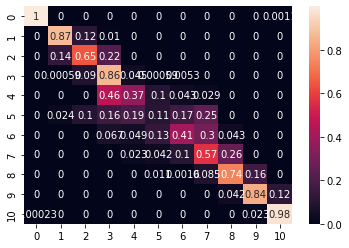

(GradientBoostingClassifier(learning_rate=0.16, max_depth=1.0,
                            min_samples_leaf=0.06, n_estimators=1000,
                            n_iter_no_change=15, random_state=17,
                            validation_fraction=0.3),
 ['phenologystageid',
  'dia',
  'min',
  'max',
  'mean',
  'std',
  'median',
  'diff',
  'variedad_CABERNET SAUVIGNON',
  'variedad_CHARDONNAY',
  'variedad_GARNACHA',
  'variedad_MAZUELA',
  'variedad_SYRACH',
  'variedad_TEMPRANILLO',
  'do_Borja',
  'do_Calatayud',
  'do_Cariñena',
  'do_Somontano',
  'longitude',
  'altitud',
  'precip__2__Cumm',
  'precip__2__Cumm 2_semanas_atras',
  'precip__2__Cumm 1_semanas_adelante',
  'chillingDD_7.0_2_Tbase_sum_Cumm',
  'chillingDD_7.0_2_Tbase_sum_Cumm 2_semanas_atras',
  'chillingDD_7.0_2_Tbase_sum_Cumm 1_semanas_adelante',
  'winkler_4.5_2_TbaseMax_Cumm',
  'winkler_4.5_2_TbaseMax_Cumm 2_semanas_atras',
  'winkler_4.5_2_TbaseMax_Cumm 1_semanas_adelante',
  'gdd_4.5_2_TbaseMax_sum_Cumm',
 

In [31]:
import seaborn as sns
mejor_modelo={}

modelos_estado=pd.read_csv(pathModelos +f'/resumen_optuna-fenologia-gb-mcc-parcelas.csv')
modelos_estado=modelos_estado.sort_values('value',ascending=False)
modelo_elegido=modelos_estado.iloc[0]
print(modelo_elegido.value)

print('Validation')
eval_model(modelo_elegido,train,vali)

Test
MCC:  0.9084109996978289
Accuracy:  0.9407751091703057
Confussion matrix:
[[10202     0     0     0     0     0     0     0     0     0     0]
 [    0   614    24     0     0     0     0     0     0     0     0]
 [    0    64   401    66     0     6     0     0     0     0     0]
 [    0     0   115  1105    25    16     4     0     0     0     0]
 [    0     0     0    74    93     2    15     7     0     0     0]
 [    0     9    10     6    49    36    11    24     0     0     0]
 [    0     0     0     5    17     4    52    25     0     0     0]
 [    0     0     0     1     6    11    25   143    60     1     0]
 [    0     0     0     0     0     0     0    18   342    68     0]
 [    0     0     0     0     0     0     0     0    75  1199   174]
 [   10     0     0     0     0     0     0     0     0    58  3048]]
Summary:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10202
         1.0       0.89      0.96      0.93

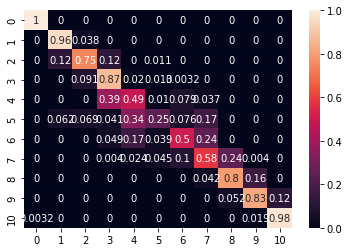

In [32]:
print('Test')
model, medidas=eval_model(modelo_elegido,train,test)

In [30]:
recalls=[]
f1s=[]
precissions=[]

In [17]:
import json
import pickle

dic_info={'type':'GB','measures':medidas}
with open(path_to_models+'pheno_info.json', 'w') as fp:
    json.dump(dic_info, fp)

# open a file, where you ant to store the data
file = open(path_to_models+'pheno.pkl', 'wb')

# dump information to that file
pickle.dump(model, file)

# close the file
file.close()

PermissionError: [Errno 13] Permission denied: '/data/proyectos/GRAPEVINE/Models/best_models/diseases/pheno_info.json'

/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


MCC:  0.9075196995278649
Accuracy:  0.9401746724890829
Confussion matrix:
[[10202     0     0     0     0     0     0     0     0     0     0]
 [    0   615    23     0     0     0     0     0     0     0     0]
 [    0    62   398    70     0     7     0     0     0     0     0]
 [    0     0   117  1100    23    20     5     0     0     0     0]
 [    0     0     0    76    91     1    16     7     0     0     0]
 [    0     9    10     6    47    34    13    26     0     0     0]
 [    0     0     0     6    12     8    54    23     0     0     0]
 [    0     0     0     1     6    11    25   144    58     2     0]
 [    0     0     0     0     0     0     0    18   343    67     0]
 [    0     0     0     0     0     0     0     0    77  1186   185]
 [    0     0     0     0     0     0     0     0     0    59  3057]]
Summary:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10202
         1.0       0.90      0.96      0.93     

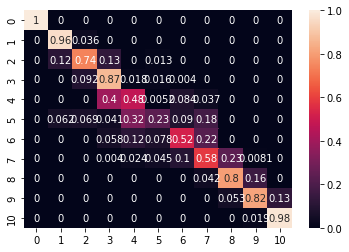

In [18]:
test=test[test['next_pheno']>=test['phenologystageid']]
preds=model.predict(test[medidas[:-1]])
for i in range(len(preds)):
    if preds[i]<test['phenologystageid'].iloc[i]:
        preds[i]=test['phenologystageid'].iloc[i]

mcc=matthews_corrcoef(test['next_pheno'],preds)
print("MCC: ",mcc)
print("Accuracy: ", accuracy_score(test['next_pheno'],preds))
#     print("F1-score: ", f1_score(Y_vali,preds))
print("Confussion matrix:")
print(confusion_matrix(test['next_pheno'],preds))
print("Summary:")
print(classification_report(test['next_pheno'],preds))

cf_matrix=confusion_matrix(test['next_pheno'],preds)
cf_matrix=cf_matrix.T/cf_matrix.sum(axis=1)
sns.heatmap(cf_matrix.T, annot=True)
plt.show()

In [ ]:
test['preds']=preds
test[(test['preds']!=test['next_pheno'])][['preds','next_pheno','phenologystageid']][['phenologystageid','next_pheno']].value_counts()

In [19]:
datos_total[['phenologystageid','next_pheno']].value_counts()

phenologystageid  next_pheno
0.0               0.0           34869
10.0              10.0          16004
9.0               9.0            5872
3.0               3.0            5325
1.0               1.0            3781
9.0               10.0           1891
2.0               2.0            1752
8.0               9.0            1501
2.0               3.0            1407
7.0               8.0            1291
8.0               8.0            1041
1.0               2.0             996
3.0               4.0             982
6.0               7.0             414
7.0               7.0             363
3.0               5.0             362
4.0               6.0             352
5.0               7.0             330
4.0               7.0             260
                  5.0             240
3.0               6.0             226
7.0               9.0             132
6.0               8.0             105
5.0               2.0             103
4.0               4.0              90
6.0               6.0

In [33]:
import seaborn as sns
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_importance = np.delete(feature_importance, 0)

    feature_names = np.array(names)
    feature_names = np.delete(feature_names, 0)
    print(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df=fi_df.iloc[:20]
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES') 

['phenologystageid', 'dia', 'min', 'max', 'mean', 'std', 'median', 'diff', 'variedad_CABERNET SAUVIGNON', 'variedad_CHARDONNAY', 'variedad_GARNACHA', 'variedad_MAZUELA', 'variedad_SYRACH', 'variedad_TEMPRANILLO', 'do_Borja', 'do_Calatayud', 'do_Cariñena', 'do_Somontano', 'longitude', 'altitud', 'precip__2__Cumm', 'precip__2__Cumm 2_semanas_atras', 'precip__2__Cumm 1_semanas_adelante', 'chillingDD_7.0_2_Tbase_sum_Cumm', 'chillingDD_7.0_2_Tbase_sum_Cumm 2_semanas_atras', 'chillingDD_7.0_2_Tbase_sum_Cumm 1_semanas_adelante', 'winkler_4.5_2_TbaseMax_Cumm', 'winkler_4.5_2_TbaseMax_Cumm 2_semanas_atras', 'winkler_4.5_2_TbaseMax_Cumm 1_semanas_adelante', 'gdd_4.5_2_TbaseMax_sum_Cumm', 'gdd_4.5_2_TbaseMax_sum_Cumm 2_semanas_atras', 'gdd_4.5_2_TbaseMax_sum_Cumm 1_semanas_adelante']


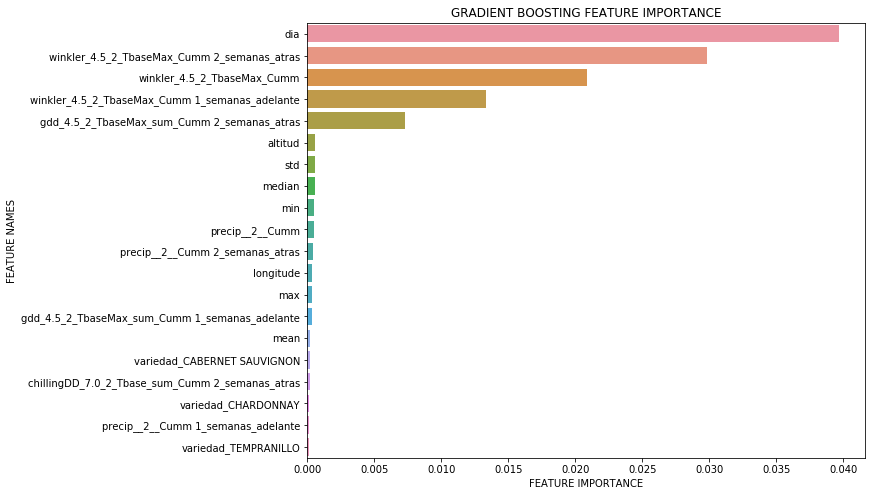

In [34]:
plot_feature_importance(model.feature_importances_,medidas[:-1],'GRADIENT BOOSTING')